In [1]:
import os

# Path to dataset (Change this based on where your dataset is)
dataset_path = "Dataset/train"

# Get list of class labels (folder names)
class_labels = sorted(os.listdir(dataset_path))

# Save to CSV file
import pandas as pd
df = pd.DataFrame(class_labels, columns=["Label"])
df.to_csv("labels.csv", index=False)

print("Labels saved to labels.csv ✅")


Labels saved to labels.csv ✅


Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.


2025-03-24 12:24:55.094117: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


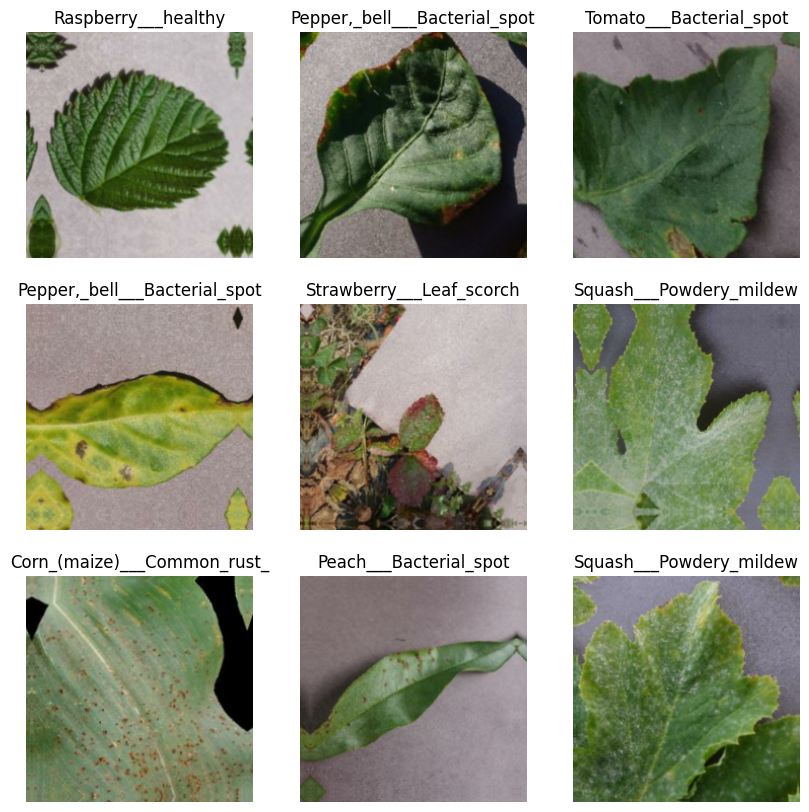

✅ Dataset Loaded & Preprocessed Successfully!


In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# 📌 Step 1: Set Dataset Path
DATASET_PATH = "Dataset"

# 📌 Step 2: Define Image Properties
IMG_SIZE = (224, 224)  # Resize all images to 224x224
BATCH_SIZE = 32  # Adjust based on GPU/CPU memory

# 📌 Step 3: Load Training Data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 📌 Step 4: Load Validation Data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# ✅ Save class names before applying transformations
class_names = train_data.class_names  # Store the class labels safely

# 📌 Step 5: Normalize Pixel Values (0-1)
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

# 📌 Step 6: Apply Data Augmentation (for training only)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

# 📌 Step 7: Optimize Performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

# 📌 Step 8: Visualize Some Images (Fixed)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):  # Take 1 batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])  # Convert tensor to numpy before indexing
        plt.axis("off")
plt.show()

print("✅ Dataset Loaded & Preprocessed Successfully!")


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models

# 📌 Load Pretrained MobileNetV3 from Keras Applications
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 📌 Freeze the Base Model
base_model.trainable = False

# 📌 Define the Model Architecture
inputs = tf.keras.Input(shape=(224, 224, 3))

# 📌 Normalize Input
x = layers.Rescaling(1./255)(inputs)

# 📌 Pass Input Through MobileNetV3 Feature Extractor
x = base_model(x)

# 📌 Global Pooling Instead of Flattening
x = layers.GlobalAveragePooling2D()(x)

# 📌 Custom Classification Layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# 📌 Create Model
model = models.Model(inputs, outputs)

# 📌 Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Print Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,878 (3.88 MB)

 Trainable params: 78,758 (307.65 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 📌 Define Dataset Path (Change this to your actual dataset directory)
dataset_path = "Dataset"

# 📌 Load Dataset with ImageDataGenerator
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

# ✅ Get Class Names (Labels)
class_names = train_dataset.class_names
print("Class Names:", class_names)

# ✅ Optimize Dataset for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


Found 54305 files belonging to 2 classes.
Using 43444 files for training.
Found 54305 files belonging to 2 classes.
Using 10861 files for validation.
Class Names: ['train', 'val']


In [6]:
# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 182s 132ms/step - accuracy: 0.7824 - loss: 0.6485 - val_accuracy: 0.8039 - val_loss: 0.4974
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 233s 172ms/step - accuracy: 0.8030 - loss: 0.5010 - val_accuracy: 0.8039 - val_loss: 0.4958
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 276s 204ms/step - accuracy: 0.8030 - loss: 0.5004 - val_accuracy: 0.8039 - val_loss: 0.4970
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 343s 253ms/step - accuracy: 0.8032 - loss: 0.5004 - val_accuracy: 0.8039 - val_loss: 0.4951
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 364s 268ms/step - accuracy: 0.8032 - loss: 0.4990 - val_accuracy: 0.8039 - val_loss: 0.4982
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 301s 221ms/step - accuracy: 0.8030 - loss: 0.4994 - val_accuracy: 0.8039 - val_loss: 0.4977
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 292s 215ms/step - accuracy: 0.8031 - loss: 0.4985 - val_accuracy: 0.8039 - val_loss: 0.4976
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 288s 212ms/step - ac

In [7]:
# Evaluate on the validation dataset
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


340/340 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.8065 - loss: 0.4928
Validation Accuracy: 80.39%


In [9]:
model.save("plant_disease_model.keras")  # Recommended format


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


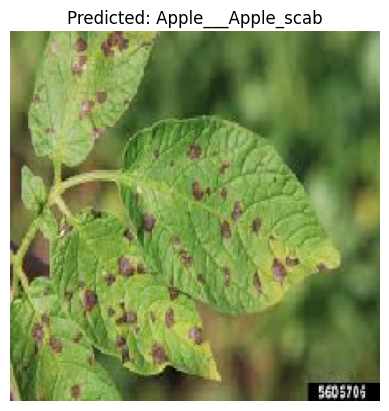

Predicted Class: Apple___Apple_scab


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image

# Load class names from CSV
csv_file = "labels.csv"  # Change this to your actual file path
df = pd.read_csv(csv_file)
class_names = df.iloc[:, 0].tolist()  # Convert column to list

# Load the JPEG image
img_path = "potato.jpeg"  # Change this to your actual test image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input

# Convert image to array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values

# Make prediction
predictions = model.predict(img_array)

# Get predicted class index
predicted_class = np.argmax(predictions[0])

# Get the class label from CSV-loaded list
predicted_label = class_names[predicted_class]

# Display image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

print(f"Predicted Class: {predicted_label}")
